# Análise da comparação entre as palavras das sentenças do CohQuAD In pt-br 

Realiza a análise da comparação entre  as palavras das sentenças dos documentos originais e perturbados dos dados  utilizando o arquivo:
- `comparacao_palavra_pX_kY.zip`

No nome do arquivo `comparacao_palavra_pX_kY.zip`, X é o número de documentos perturbados e Y o valor de top K predições. 

# 1 Preparação do ambiente

Preparação do ambiente para execução do script.

## 1.1 Tempo inicial de processamento

In [1]:
# Import das bibliotecas.
import time
import datetime

# Marca o tempo de início do processamento
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [2]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [3]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [4]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documentoLimpo = re.compile("<.*?>")
    return re.sub(documentoLimpo, "", documento)

Funções auxiliares de arquivos

In [5]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [6]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [7]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [8]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempoArredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempoArredondado))    

Classe(ModelArguments) de definição dos parâmetros do modelo

In [9]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )    
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    sentenciar_documento: bool = field(
        default=True,
        metadata={"help": "Dividir o documento em sentenças(frases)."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )    
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={"help": "habilita o carragamento de mcl ajustado."},
    )
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos a serem perturbados a partir do original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de palavras a serem recuperadas mais próximas da máscara."},
    )

Biblioteca de limpeza de tela


In [10]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [11]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4 Identificando o ambiente Colab

In [12]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [13]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [14]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def getDeviceGPU():
    """
    Retorna um dispositivo de GPU se disponível ou CPU.
    
    Retorno:
    `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [15]:
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Conecta o modelo ao device

In [16]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def conectaGPU(model, device):
    """
      Conecta um modelo BERT a GPU.

      Parâmetros:
        `model` - Um modelo BERT carregado.       
        `device` - Um device de GPU.     
    
      Retorno:
        `model` - Um objeto model BERT conectado a GPU.     
    """
    # Associa a GPU ao modelo.
    model.to(device)

    # Se existe GPU disponível.
    if torch.cuda.is_available():    
        # Diga ao pytorch para rodar este modelo na GPU.
        logging.info("Pytorch rodando o modelo na GPU.")
        model.cuda()
        
    else:
        logging.info("Pytorch rodando sem GPU.")

    return model

Memória

Memória disponível no ambiente

In [17]:
# Import das bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [18]:
# Import das bibliotecas.
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")     

Mounted at /content/drive


## 1.7 Instalação do wandb

Instalação

In [19]:
!pip install --upgrade wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 7.5 MB/s 
     |████████████████████████████████| 162 kB 65.2 MB/s 
     |████████████████████████████████| 181 kB 52.2 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 158 kB 52.9 MB/s 
     |████████████████████████████████| 157 kB 51.2 MB/s 
     |████████████████████████████████| 157 kB 48.5 MB/s 
     |████████████████████████████████| 157 kB 50.9 MB/s 
     |████████████████████████████████| 157 kB 53.8 MB/s 
     |████████████████████████████████| 157 kB 65.8 MB/s 
     |████████████████████████████████| 157 kB 51.1 MB/s 
     |████████████████████████████████| 157 kB 70.3 MB/s 
     |████████████████████████████████| 156 kB 65.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=6df34154005044b183672fdf126f05c04822b58a65d0af67e049480e679c

# 2 Parametrização

## Gerais

In [20]:
# Definição dos parâmetros a serem avaliados
#Quantidade de documentos a serem perturbados a partir do original.
DOCUMENTOS_PERTURBADOS = 1

#Quantidade de palavras a serem recuperadas mais próximas da máscara.
TOP_K_PREDICAO = 1

## Específicos

Parâmetros do modelo

In [21]:
# Definição dos parâmetros do Modelo.
model_args = ModeloArgumentosMedida(     
    max_seq_len = 512,    
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-large-portuguese-cased/bert-large-portuguese-cased_pytorch_checkpoint.zip",
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-base-portuguese-cased/bert-base-portuguese-cased_pytorch_checkpoint.zip",
    
    #pretrained_model_name_or_path = "bert-large-cased",
    #pretrained_model_name_or_path = "bert-base-cased"
    pretrained_model_name_or_path = "neuralmind/bert-large-portuguese-cased",
    #pretrained_model_name_or_path = "neuralmind/bert-base-portuguese-cased",    
    #pretrained_model_name_or_path = "bert-base-multilingual-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-uncased",

    #modelo_spacy = "en_core_web_lg",
    #modelo_spacy = "en_core_web_md",
    #modelo_spacy = "en_core_web_sm",
    modelo_spacy = "pt_core_news_lg",
    #modelo_spacy = "pt_core_news_md",
    #modelo_spacy = "pt_core_news_sm",
    
    versao_modelo_spacy = "3.2.0",
    sentenciar_documento = True,
    do_lower_case = False,   # default True  
    output_attentions = False,    # default False
    output_hidden_states = True, # default False, se True retorna todas as camadas do modelo para as operações de soma e concatenação
    usar_mcl_ajustado = False, # Especifica se deve ser carregado um MCL ajustado ou pré-treinado. Necessário especificar o tipo do modelo em pretrained_model_name_or_path. 
    documentos_perturbados = DOCUMENTOS_PERTURBADOS, # Quantidade de documentos a serem perturbados a partir do original.
    top_k_predicao = TOP_K_PREDICAO, # Conjunto de valores: 1, 10, 100, 500 e 1000. Quantidade de palavras a serem recuperadas mais próximas da máscara.
)

## Nome do diretório dos arquivos de dados

In [22]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "COHQUAD_IN_PTBR"

## Define o caminho para os arquivos de dados

In [23]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

## Configuração do tamanho da fonte dos gráficos

In [24]:
# Import de bibliotecas
import matplotlib

TAMANHO_FONTE = 16
matplotlib.rc("font", size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc("axes", titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc("axes", labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc("xtick", labelsize=TAMANHO_FONTE-2)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc("ytick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc("legend", fontsize=TAMANHO_FONTE-2)  # Tamanho da fonte da legenda
matplotlib.rc("figure", titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

# 3 Estatísticas comparação das palavras



## 3.1 Carregamento dos arquivos de dados originais e perturbados

### 3.1.1 Especifica os nomes dos arquivos de dados



In [25]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.1.2 Cria o diretório local para receber os dados

In [26]:
# Import de bibliotecas
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório criado: /content/COHQUAD_IN_PTBR


### 3.1.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [27]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [28]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

INFO:root:Terminei a descompactação!


### 3.1.4 Carregamento das lista com os dados dos arquivos originais

#### Carrega o arquivo dos dados originais e POS

In [29]:
# Import de bibliotecas
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO ORIGINAIS: 20.
INFO:root:TERMINADO ORIGINAIS POS: 20.


In [30]:
lista_documentos_originais.sample(5)

,id,sentencas,documento
2,3p0,['Como empilhar elementos em uma fila?'],Como empilhar elementos em uma fila?
1,2p0,['Como desenfileirar elementos em uma pilha?'],Como desenfileirar elementos em uma pilha?
13,14p0,['O que é uma fila e como empilhar um elemento...,O que é uma fila e como empilhar um elemento n...
15,16p0,['O que é uma pilha e como enfileirar e desenf...,O que é uma pilha e como enfileirar e desenfil...
14,15p0,['O que é uma fila e como empilhar e desempilh...,O que é uma fila e como empilhar e desempilhar...


In [31]:
lista_documentos_originais_pos.sample(5)

,id,pos_documento
19,20p0,"[[['Em', 'uma', 'fila', 'a', 'operação', 'de',..."
15,16p0,"[[['O', 'que', 'é', 'uma', 'pilha', 'e', 'como..."
10,11p0,"[[['O', 'que', 'é', 'uma', 'pilha', 'e', 'como..."
9,10p0,"[[['O', 'que', 'é', 'uma', 'pilha', 'e', 'como..."
2,3p0,"[[['Como', 'empilhar', 'elementos', 'em', 'uma..."


#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [32]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO CORREÇÃO ORIGINAIS: 20.
INFO:root:TERMINADO CORREÇÃO ORIGINAIS POS: 20.


#### Criando dados indexados originais

In [33]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_indexado = lista_documentos_originais.set_index(["id"])
lista_documentos_originais_indexado.head()

,sentencas,documento
id,,
1p0,[Como enfileirar elementos em uma pilha?],Como enfileirar elementos em uma pilha?
2p0,[Como desenfileirar elementos em uma pilha?],Como desenfileirar elementos em uma pilha?
3p0,[Como empilhar elementos em uma fila?],Como empilhar elementos em uma fila?
4p0,[Como empilhar e desempilhar elementos em uma ...,Como empilhar e desempilhar elementos em uma f...
5p0,[Como empilhar elementos em uma estrutura de d...,Como empilhar elementos em uma estrutura de da...


In [34]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.set_index(["id"])
lista_documentos_originais_pos_indexado.head()

,pos_documento
id,
1p0,"[[[Como, enfileirar, elementos, em, uma, pilha..."
2p0,"[[[Como, desenfileirar, elementos, em, uma, pi..."
3p0,"[[[Como, empilhar, elementos, em, uma, fila, ?..."
4p0,"[[[Como, empilhar, e, desempilhar, elementos, ..."
5p0,"[[[Como, empilhar, elementos, em, uma, estrutu..."


#### Carrega o arquivo dos dados perturbados e POS

In [35]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO PERTURBADOS: 20.
INFO:root:TERMINADO PERTURBADOS POS: 20.


AlgUns csv estão com os nomes das colunas errados

In [36]:
lista_documentos_perturbados = lista_documentos_perturbados.rename(columns={'documentoPerturbado': 'documento_perturbado'})

In [37]:
lista_documentos_perturbados.sample(5)

,id,perturbado,documento_perturbado,sentencas
17,18p0_pert_0,['Como são implementadas as operações de separ...,Como são implementadas as operações de separar...,[['Como são implementadas as operações de [MAS...
9,10p0_pert_0,['O que é uma pilha e como identificar seu ele...,O que é uma pilha e como identificar seu eleme...,[['O que é uma pilha e como [MASK] seu element...
4,5p0_pert_0,['Como adicionar elementos em uma estrutura de...,Como adicionar elementos em uma estrutura de d...,[['Como [MASK] elementos em uma estrutura de d...
16,17p0_pert_0,['Como são implementadas as operações de empil...,Como são implementadas as operações de empilha...,[['Como são implementadas as operações de empi...
13,14p0_pert_0,['O que é uma fila e como colocar um elemento ...,O que é uma fila e como colocar um elemento ne...,[['O que é uma fila e como [MASK] um elemento ...


In [38]:
lista_documentos_perturbados_pos.sample(5)

,id,pos_documento
18,19p0_pert_0,"[[['Em', 'uma', 'pilha', 'a', 'operação', 'de'..."
4,5p0_pert_0,"[[['Como', 'adicionar', 'elementos', 'em', 'um..."
14,15p0_pert_0,"[[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'..."
2,3p0_pert_0,"[[['Como', 'colocar', 'elementos', 'em', 'uma'..."
19,20p0_pert_0,"[[['Em', 'uma', 'fila', 'a', 'operação', 'de',..."


#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [39]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO CORREÇÃO PERTURBADO: 20.
INFO:root:TERMINADO CORREÇÃO PERTURBADO POS: 20.


#### Criando dados indexados perturbados

In [40]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.set_index(["id"])
lista_documentos_perturbados_indexado.head()

,perturbado,documento_perturbado,sentencas
id,,,
1p0_pert_0,[Como colocar elementos em uma pilha ?],Como colocar elementos em uma pilha ?,"[[Como [MASK] elementos em uma pilha ?, enfile..."
2p0_pert_0,[Como colocar elementos em uma pilha ?],Como colocar elementos em uma pilha ?,"[[Como [MASK] elementos em uma pilha ?, desenf..."
3p0_pert_0,[Como colocar elementos em uma fila ?],Como colocar elementos em uma fila ?,"[[Como [MASK] elementos em uma fila ?, empilha..."
4p0_pert_0,[Como separar e desempilhar elementos em uma f...,Como separar e desempilhar elementos em uma fi...,[[Como [MASK] e desempilhar elementos em uma f...
5p0_pert_0,[Como adicionar elementos em uma estrutura de ...,Como adicionar elementos em uma estrutura de d...,[[Como [MASK] elementos em uma estrutura de da...


In [41]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.set_index(["id"])
lista_documentos_perturbados_pos_indexado.head()

,pos_documento
id,
1p0_pert_0,"[[[Como, colocar, elementos, em, uma, pilha, ?..."
2p0_pert_0,"[[[Como, colocar, elementos, em, uma, pilha, ?..."
3p0_pert_0,"[[[Como, colocar, elementos, em, uma, fila, ?]..."
4p0_pert_0,"[[[Como, separar, e, desempilhar, elementos, e..."
5p0_pert_0,"[[[Como, adicionar, elementos, em, uma, estrut..."


### 5.1.5 Agrupar os dados originais e perturbados

In [42]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados):
  print("Processando",len(lista_documentos_originais),"documentos originais")

  lista_documentos_agrupados = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha_documento in lista_documentos_originais_bar: 
    #if i < 2:
      #print("linha_documento:",linha_documento)
      # Recupera o id do documento
      id_documento = linha_documento[0]     
      #print("id_documento:",id_documento)     
  
      # Carrega a lista das sentenças do documento
      lista_sentenca_documento = linha_documento[1]    
      #print("\nlista_sentenca_documento:",lista_sentenca_documento)
      #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

      # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
      lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])

      # Percorre os documentos perturbados apartir do original
      for j in range(0, model_args.documentos_perturbados):

        # Id do documento perturbado
        id_perturbado = str(id_documento) + "_pert_" + str(j)

        # localiza o documento perturbado de acordo com o tipo armazenado        
        # Os conjuntos de dados possuem diferentes formas de armazendo        
        documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
        # Recupera a sentença do documento perturbado
        lista_perturbado = documento_perturbado[0]
                      
        # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
        lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

  logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

  # Cria o dataframe da lista
  lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

  # Corrige os tipos dos dados da lista agrupada
  tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

  lista_documentos_agrupados = lista_documentos_agrupados.astype(tipos)

  return lista_documentos_agrupados

In [43]:
# Importa das bibliotecas
import pandas as pd

print("Analisando documentos originais e perturbados")
# Concatena as listas de documentos originais e perturbados
lista_documentos_agrupados = agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados)
lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])

# Corrige o tipo de dado da coluna id da lista
tipos = {"id": str}
lista_documentos_agrupados_pos = lista_documentos_agrupados_pos.astype(tipos)

Analisando documentos originais e perturbados
Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

INFO:root:TERMINADO AGRUPAMENTO: 40.


In [44]:
logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

INFO:root:TERMINADO AGRUPAMENTO: 40.


In [45]:
lista_documentos_agrupados.sample(5)

,id,sentencas,documento,classe
32,17p0,[Como são implementadas as operações de empilh...,Como são implementadas as operações de empilha...,1
29,15p0_pert_0,[O que é uma fila e como organizar e desempilh...,O que é uma fila e como organizar e desempilha...,0
31,16p0_pert_0,[O que é uma pilha e como separar e desenfilei...,O que é uma pilha e como separar e desenfileir...,0
3,2p0_pert_0,[Como colocar elementos em uma pilha ?],Como colocar elementos em uma pilha ?,0
37,19p0_pert_0,[Em uma pilha a operação de carga ocorre em qu...,Em uma pilha a operação de carga ocorre em qua...,0


In [46]:
logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(lista_documentos_agrupados_pos)))

INFO:root:TERMINADO AGRUPAMENTO POS: 40.


In [47]:
lista_documentos_agrupados_pos.sample(5)

,id,pos_documento
2,3p0_pert_0,"[[[Como, colocar, elementos, em, uma, fila, ?]..."
5,6p0_pert_0,"[[[Como, introduzir, e, desempilhar, elementos..."
14,15p0_pert_0,"[[[O, que, é, uma, fila, e, como, organizar, e..."
6,7p0_pert_0,"[[[Como, colocar, elementos, em, uma, fila, ?]..."
2,3p0,"[[[Como, empilhar, elementos, em, uma, fila, ?..."


#### Criar dados indexados

In [48]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_indexado = lista_documentos_agrupados.set_index(["id"])
lista_documentos_agrupados_indexado.head()

,sentencas,documento,classe
id,,,
1p0,[Como enfileirar elementos em uma pilha?],Como enfileirar elementos em uma pilha?,1
1p0_pert_0,[Como colocar elementos em uma pilha ?],Como colocar elementos em uma pilha ?,0
2p0,[Como desenfileirar elementos em uma pilha?],Como desenfileirar elementos em uma pilha?,1
2p0_pert_0,[Como colocar elementos em uma pilha ?],Como colocar elementos em uma pilha ?,0
3p0,[Como empilhar elementos em uma fila?],Como empilhar elementos em uma fila?,1


In [49]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_pos_indexado = lista_documentos_agrupados_pos.set_index(["id"])
lista_documentos_agrupados_pos_indexado.head()

,pos_documento
id,
1p0,"[[[Como, enfileirar, elementos, em, uma, pilha..."
2p0,"[[[Como, desenfileirar, elementos, em, uma, pi..."
3p0,"[[[Como, empilhar, elementos, em, uma, fila, ?..."
4p0,"[[[Como, empilhar, e, desempilhar, elementos, ..."
5p0,"[[[Como, empilhar, elementos, em, uma, estrutu..."


## 3.2 Carregamento do arquivo de dado comparação 

### 3.2.1 Especifica os nomes dos arquivos de dados



In [50]:
# Nome do arquivo
NOME_ARQUIVO_COMPARACAO = "comparacao_palavra_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_COMPARACAO_COMPACTADO = "comparacao_palavra_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.2.2 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [51]:
# Importando as bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório já existe: /content/COHQUAD_IN_PTBR


In [52]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  # Copia o arquivo de comparações do google drive para a diretório local
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_COMPARACAO_COMPACTADO" "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_COMPACTADO"
  
  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [53]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Descompactação realizada!")

INFO:root:Descompactação realizada!


### 3.2.4 Carregamento das lista com os dados do arquivo


In [54]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_comparacao_palavra = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_COMPARACAO, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_comparacao_palavra)))

INFO:root:TERMINADO ORIGINAIS: 2240.


In [55]:
lista_comparacao_palavra.sample(5)

,id,index_documento,index_sentenca,index_wi,wi,pos_i,index_wj,wj,pos_j,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
436,7p0,12,0,3,em,ADP,5,fila,NOUN,0.775982,26.248705,1230.4672,0.703405,30.791336,1428.0680
923,12p0,22,0,1,que,PRON,10,nela,PRON,0.442003,43.234051,2109.6987,0.442003,43.234051,2109.6987
2154,20p0,38,0,5,de,SCONJ,7,ocorre,VERB,0.555125,40.336098,1903.8013,0.555125,40.336098,1903.8013
1166,13p0_pert_0,25,0,9,elemento,NOUN,11,?,PUNCT,0.561705,37.887566,1832.9197,0.561705,37.887566,1832.9197
1541,16p0_pert_0,31,0,0,O,PRON,8,e,CCONJ,0.708994,29.049364,1426.1659,0.708994,29.049364,1426.1659


### 3.5.5 Criando dados indexados

In [56]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_palavra_indexado = lista_comparacao_palavra.set_index(["id", "index_sentenca", "index_wi", "index_wj"])
lista_comparacao_palavra_indexado.head()

index_documento    wi  pos_i  \
id  index_sentenca index_wi index_wj                                 
1p0 0              0        1                       0  Como  SCONJ   
                            2                       0  Como  SCONJ   
                            3                       0  Como  SCONJ   
                            4                       0  Como  SCONJ   
                            5                       0  Como  SCONJ   

                                              wj pos_j  cos_mean   euc_mean  \
id  index_sentenca index_wi index_wj                                          
1p0 0              0        1         enfileirar  VERB  0.761694  25.747267   
                            2          elementos  NOUN  0.617482  35.318653   
                            3                 em   ADP  0.650087  33.424171   
                            4                uma   DET  0.704987  29.126415   
                            5              pilha  NOUN  0.603006  34.711918   

                                       man_mean   cos_max    euc_max  \
id  index_sentenca index_wi index_wj                                   
1p0 0              0        1         1281.7346  0.663389  32.028095   
                            2         1718.4980  0.617482  35.318653   
                            3         1681.7717  0.650087  33.424171   
                            4         1443.1240  0.704987  29.126415   
                            5         1627.4218  0.603006  34.711918   

                                        man_max  
id  index_sentenca index_wi index_wj             
1p0 0              0        1         1584.6208  
                            2         1718.4980  
                            3         1681.7717  
                            4         1443.1240  
                            5         1627.4218

## 3.3 Estatísticas

### Estatísticas das medidas dos pares de palavras

In [57]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_palavra[["cos_mean", "euc_mean", "man_mean", "cos_max", "euc_max", "man_max" ]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,0.633364,33.104774,1592.776590,0.611505,34.599377,1667.621431
std,0.118872,4.791607,204.416540,0.120943,4.973750,218.939059
min,0.066207,15.401643,737.115970,0.066207,19.861835,931.861000
25%,0.585832,29.952577,1463.559075,0.557982,31.565753,1537.840525
50%,0.647013,32.969604,1604.215850,0.618849,34.873610,1689.688400
75%,0.701122,36.218154,1733.797975,0.679508,38.065288,1819.236025
max,0.901491,47.294228,2129.081300,0.888144,48.315918,2301.813700


### Estatísticas das maiores discrepâncias por documento

In [58]:
coluna_discrepancia_cos = "min"
coluna_discrepancia_euc = "max"
coluna_discrepancia_man = "max"

discrepancias  = lista_comparacao_palavra.groupby("id").agg({"cos_mean":[coluna_discrepancia_cos], 
                                                             "euc_mean":[coluna_discrepancia_euc], 
                                                             "man_mean":[coluna_discrepancia_man],
                                                             "cos_max":[coluna_discrepancia_cos], 
                                                             "euc_max":[coluna_discrepancia_euc], 
                                                             "man_max":[coluna_discrepancia_man],
                                                             })

In [59]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
,min,max,max,min,max,max
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.458644,41.206778,1931.448440,0.442176,42.050028,1998.253833
std,0.158790,3.955421,139.044865,0.155064,3.693326,155.655841
min,0.066207,35.174438,1711.873300,0.066207,35.174438,1711.873300
25%,0.442243,37.564875,1799.033825,0.436243,39.269594,1902.712125
50%,0.500717,41.844402,1927.131400,0.470026,42.424145,2047.262450
75%,0.581977,44.788804,2067.735900,0.553552,44.788804,2097.096100
max,0.610777,47.294228,2129.081300,0.589914,48.315918,2301.813700


### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [60]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

In [61]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])

1 uma 40
2 ? 40
3 e 28
4 em 24
5 elementos 23
6 fila 23
7 Como 20
8 O 16
9 que 16
10 é 16
11 como 16
12 pilha 15
13 de 14
14 desempilhar 12
15 elemento 12
16 empilhar 10
17 um 8
18 nela 8
19 desenfileirar 7
20 estrutura 7


## 3.4 Estatísticas das discrepâncias por classe moforsintática

### COS

In [62]:
medida = "cos"

#### MEAN

In [63]:
estrategia_pooling = "mean"
coluna_equacao = medida + "_" + estrategia_pooling

In [64]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,188.000000,0.681513,0.069833,0.498083,0.625188,0.678462,0.734370,0.838898
ADV,159.000000,0.643960,0.114000,0.103438,0.580012,0.656134,0.714910,0.829644
AUX,192.000000,0.613450,0.111485,0.066451,0.570890,0.631136,0.675937,0.827388
CCONJ,166.000000,0.559949,0.218622,0.101886,0.530628,0.637151,0.712335,0.862566
DET,349.000000,0.661481,0.092658,0.154105,0.629327,0.656547,0.714413,0.859053
NOUN,447.000000,0.632561,0.082731,0.132799,0.587003,0.636999,0.686226,0.871600
PRON,346.000000,0.608261,0.125166,0.066207,0.525838,0.593653,0.701619,0.814802
SCONJ,129.000000,0.644839,0.110884,0.096426,0.593859,0.650087,0.718030,0.806643
VERB,264.000000,0.644824,0.114091,0.104145,0.603611,0.659544,0.703352,0.901491


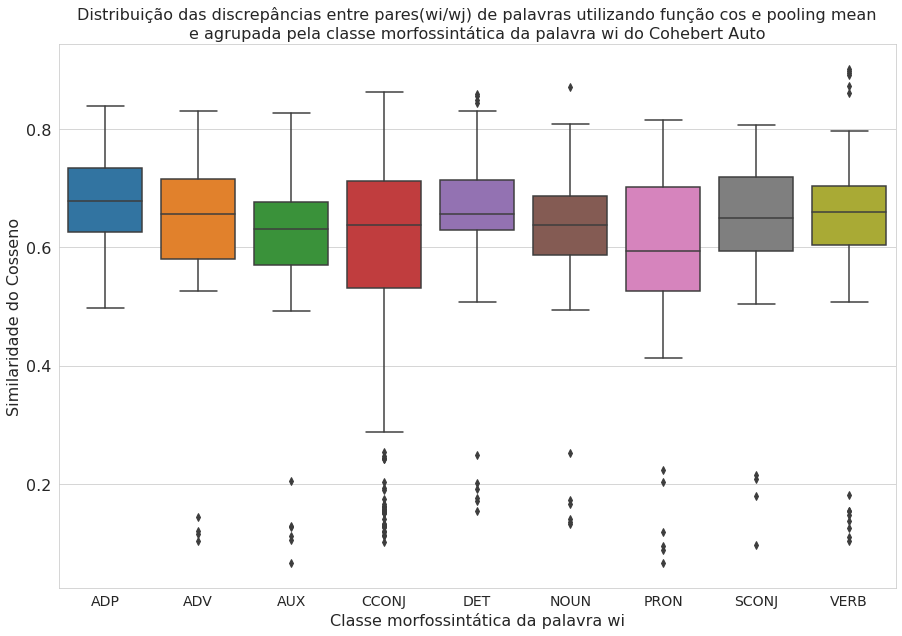

In [65]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

# Mostra o gráfico
plt.show()

In [66]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,178.000000,0.671743,0.097570,0.101886,0.637490,0.674396,0.716496,0.859053
ADV,122.000000,0.658953,0.093642,0.150619,0.628521,0.663834,0.711806,0.901491
AUX,36.000000,0.738150,0.038267,0.678963,0.701619,0.740082,0.757418,0.810290
CCONJ,148.000000,0.512565,0.241414,0.066207,0.207634,0.602893,0.679153,0.862566
DET,363.000000,0.652511,0.103580,0.119810,0.599441,0.655600,0.713000,0.897620
NOUN,656.000000,0.619122,0.100994,0.127351,0.561572,0.631757,0.692137,0.872450
PRON,105.000000,0.616920,0.091108,0.436769,0.548680,0.626235,0.681893,0.780183
PUNCT,394.000000,0.647146,0.097827,0.132372,0.592879,0.635469,0.692844,0.845937
SCONJ,36.000000,0.676272,0.066639,0.521147,0.648342,0.673213,0.714321,0.794229


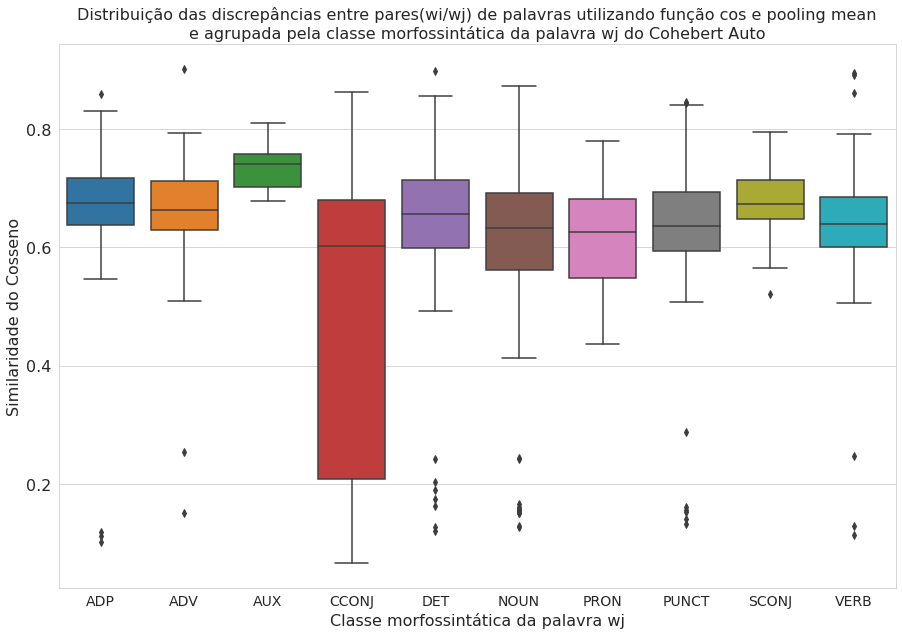

In [67]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

# Mostra o gráfico
plt.show()

#### MAX

In [68]:
estrategia_pooling = "max"
coluna_equacao = medida + "_" + estrategia_pooling

In [69]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,188.000000,0.670659,0.072013,0.498083,0.617813,0.665994,0.718058,0.838898
ADV,159.000000,0.615919,0.117620,0.103438,0.558139,0.604258,0.677752,0.829644
AUX,192.000000,0.600284,0.116035,0.066451,0.540066,0.622993,0.675088,0.827388
CCONJ,166.000000,0.543754,0.217065,0.081977,0.515115,0.592332,0.705151,0.862566
DET,349.000000,0.647750,0.097239,0.154105,0.614210,0.652953,0.695560,0.859053
NOUN,447.000000,0.604701,0.083239,0.132799,0.560744,0.600658,0.657235,0.871600
PRON,346.000000,0.599900,0.129576,0.066207,0.505610,0.587367,0.701619,0.814802
SCONJ,129.000000,0.625050,0.111262,0.096426,0.582328,0.626541,0.674981,0.806643
VERB,264.000000,0.589677,0.113173,0.082438,0.548021,0.597183,0.649796,0.888144


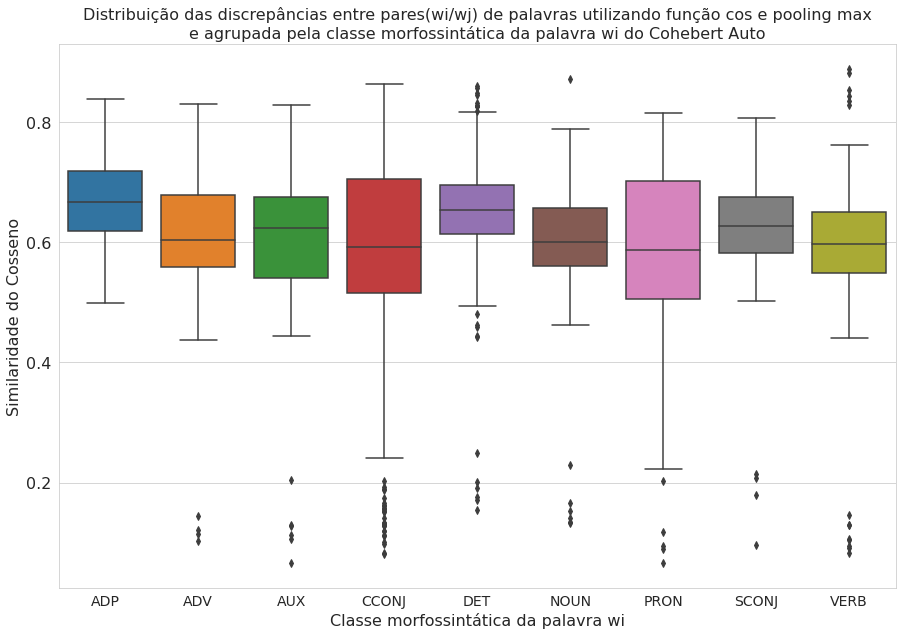

In [70]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

# Mostra o gráfico
plt.show()

In [71]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,178.000000,0.650308,0.100192,0.101886,0.604781,0.656355,0.700992,0.859053
ADV,122.000000,0.626880,0.111814,0.097815,0.541783,0.651324,0.683660,0.888144
AUX,36.000000,0.738150,0.038267,0.678963,0.701619,0.740082,0.757418,0.810290
CCONJ,148.000000,0.507358,0.242753,0.066207,0.207634,0.602893,0.677813,0.862566
DET,363.000000,0.636965,0.106689,0.083782,0.586652,0.640900,0.690645,0.881570
NOUN,656.000000,0.592217,0.098594,0.110994,0.539018,0.589621,0.661712,0.871600
PRON,105.000000,0.606764,0.090666,0.436769,0.547007,0.611781,0.660338,0.780183
PUNCT,394.000000,0.634253,0.103250,0.132372,0.578757,0.619301,0.679508,0.845937
SCONJ,36.000000,0.670860,0.073231,0.521147,0.645701,0.672962,0.714321,0.794229


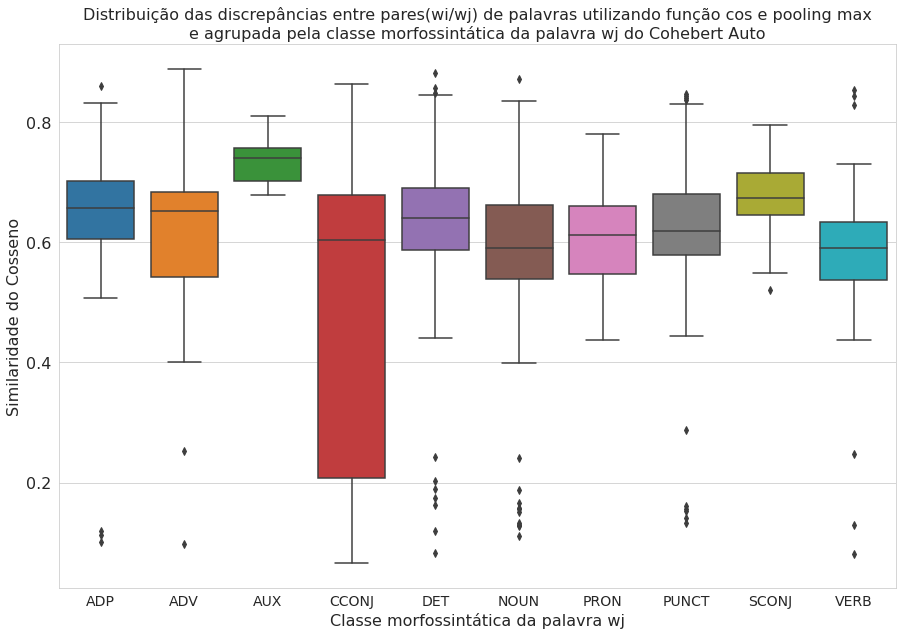

In [72]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

# Mostra o gráfico
plt.show()

### EUC

In [73]:
medida = "euc"

#### MEAN

In [74]:
estrategia_pooling = "mean"
coluna_equacao = medida + "_" + estrategia_pooling

In [75]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,188.000000,31.734126,3.972266,22.652691,28.930563,31.944243,34.783179,41.861313
ADV,159.000000,32.635825,4.829992,22.391808,29.266146,32.220421,36.306824,44.029022
AUX,192.000000,33.967041,4.273330,22.295998,31.289557,33.217068,36.496031,46.184963
CCONJ,166.000000,33.997481,6.683038,19.983543,29.120763,33.284525,39.180961,47.294228
DET,349.000000,31.687707,4.226029,20.465446,29.188120,31.959972,33.661049,41.713959
NOUN,447.000000,33.931099,3.511832,19.861835,31.717914,33.944492,36.414860,44.852982
PRON,346.000000,34.255666,5.748294,23.147795,29.739237,34.888174,38.278587,46.412331
SCONJ,129.000000,32.371011,4.652774,23.803923,28.894548,32.526810,35.379818,44.989876
VERB,264.000000,32.499230,4.668590,15.401643,29.659443,32.766342,35.754597,44.601128


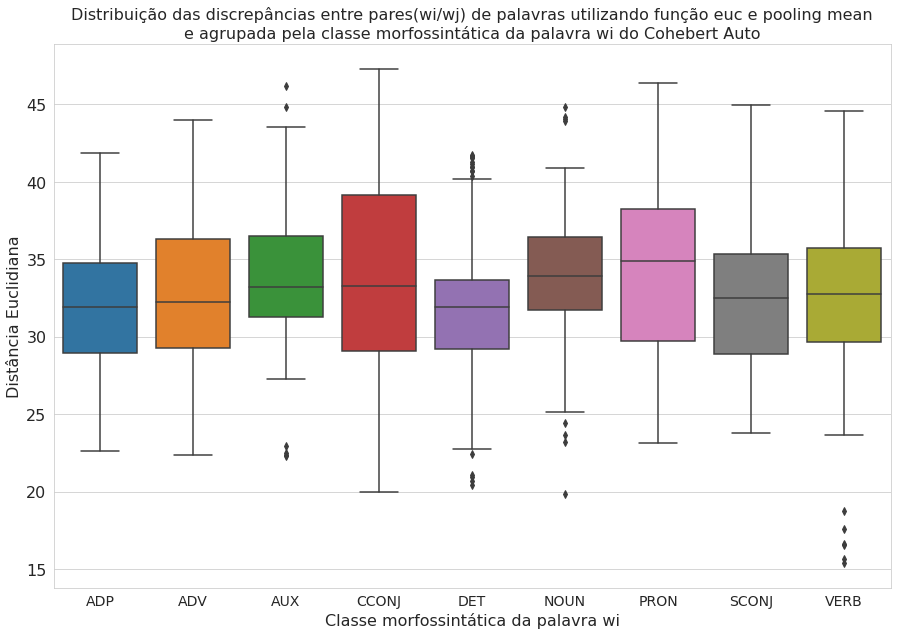

In [76]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")

# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

In [77]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,178.000000,32.010393,4.013842,20.724178,29.281207,32.359097,34.514119,46.192616
ADV,122.000000,31.645003,3.893624,15.401643,29.090382,32.250689,33.492640,42.421833
AUX,36.000000,28.360706,2.074315,23.509779,27.705519,28.729403,29.943392,31.245012
CCONJ,148.000000,34.712235,6.248253,19.983543,30.586782,33.838923,39.816969,46.412331
DET,363.000000,31.861113,4.501779,15.669219,29.025205,32.047844,35.023977,43.919960
NOUN,656.000000,34.625701,4.627418,17.615896,31.372406,34.463102,38.279328,47.294228
PRON,105.000000,35.098737,4.531194,26.294678,31.906261,35.034664,38.218777,44.044922
PUNCT,394.000000,32.316816,4.608555,21.304848,29.414932,32.926039,35.556677,43.134327
SCONJ,36.000000,31.290965,3.730082,24.415045,29.254545,31.180383,33.721313,39.882729


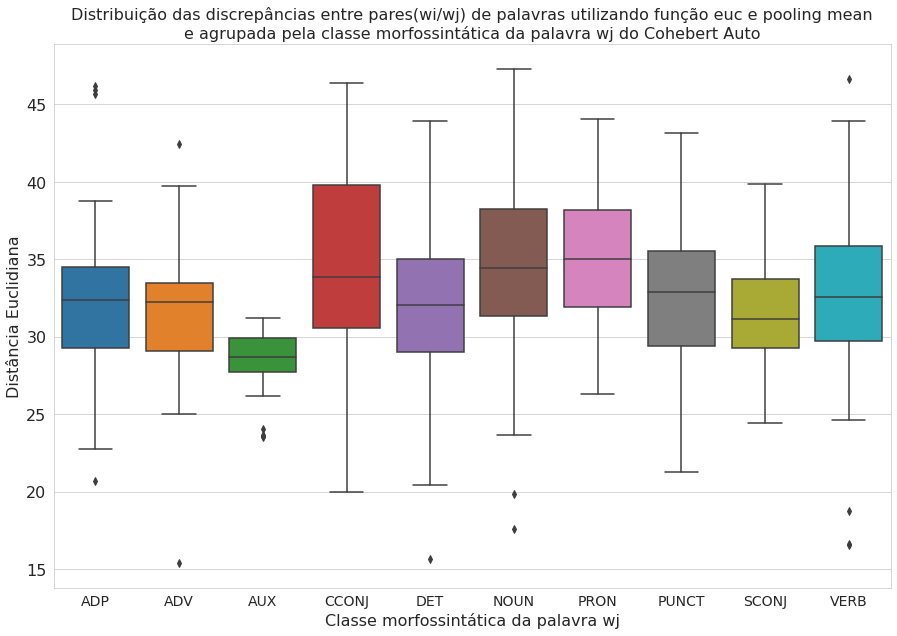

In [78]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAX

In [79]:
estrategia_pooling = "max"
coluna_equacao = medida + "_" + estrategia_pooling

In [80]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,188.000000,32.425012,4.075195,22.652691,29.538367,32.552134,35.381528,41.861313
ADV,159.000000,34.486168,5.188501,22.391808,31.176330,35.357391,38.535738,44.029022
AUX,192.000000,34.877662,4.635257,22.295998,31.508073,33.983143,38.401982,46.184963
CCONJ,166.000000,35.246955,6.856710,19.983543,29.856256,35.843567,40.036280,48.315918
DET,349.000000,32.609735,4.482692,20.465446,30.226561,32.359615,34.674065,44.299175
NOUN,447.000000,35.793837,3.286657,19.861835,33.829390,36.102421,37.871792,44.852982
PRON,346.000000,34.860299,6.054861,23.147795,29.943392,35.793379,39.640575,46.647213
SCONJ,129.000000,33.664403,4.696663,23.803923,31.172213,33.902340,36.711937,44.989876
VERB,264.000000,36.329102,4.345130,20.385046,33.820752,36.373812,39.146060,46.864994


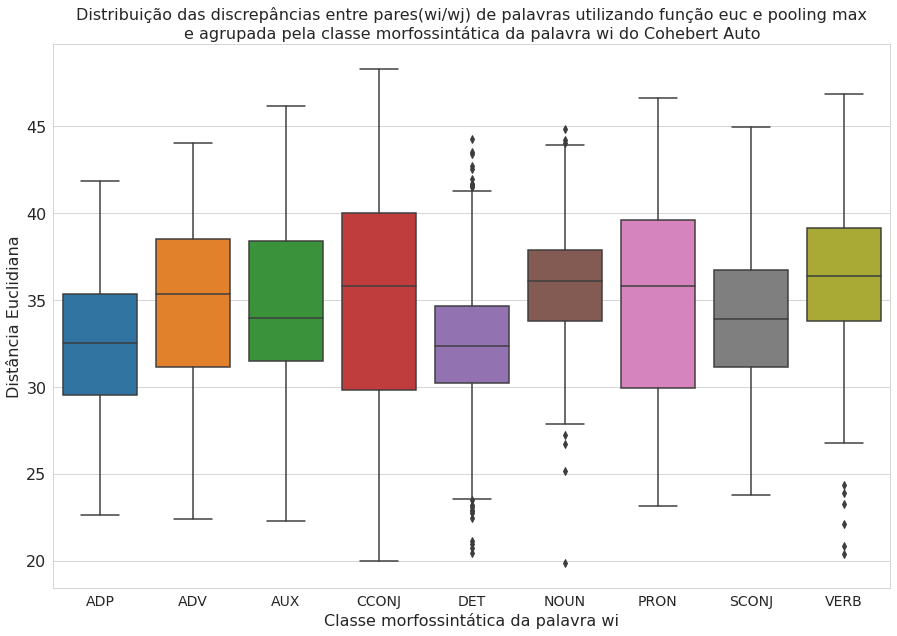

In [81]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")

# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

In [82]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,178.000000,33.357477,4.233457,20.724178,31.220036,33.348974,35.877977,46.192616
ADV,122.000000,33.915550,5.248442,20.385046,31.003243,33.042807,38.124203,48.277248
AUX,36.000000,28.360706,2.074315,23.509779,27.705519,28.729403,29.943392,31.245012
CCONJ,148.000000,35.212333,6.504932,19.983543,30.599481,34.491495,41.309015,46.864994
DET,363.000000,32.937608,4.737816,20.465446,30.287800,33.029957,35.925812,48.315918
NOUN,656.000000,36.463946,4.292800,19.861835,33.333942,36.764717,39.344757,47.294228
PRON,105.000000,35.703389,4.516203,26.294678,33.165188,36.568993,38.897587,44.044922
PUNCT,394.000000,33.169168,4.943202,21.304848,31.117859,33.813311,36.665784,43.530407
SCONJ,36.000000,31.679929,4.142360,24.415045,29.254545,31.551686,34.266566,39.882729


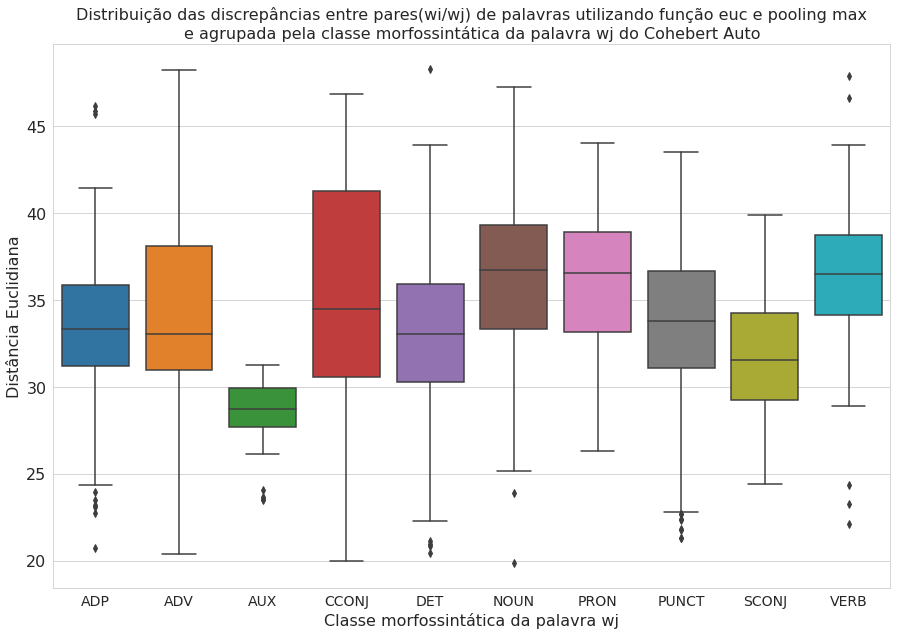

In [83]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

### MAN

In [84]:
medida = "man"

#### MEAN

In [85]:
estrategia_pooling = "mean"
coluna_equacao = medida + "_" + estrategia_pooling

In [86]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,188.000000,1542.640880,194.735794,1081.562100,1407.573025,1561.384800,1678.377175,1966.171100
ADV,159.000000,1598.442557,210.493572,1095.593100,1463.130650,1601.563500,1747.678700,1973.008200
AUX,192.000000,1629.334692,160.326614,1107.207200,1539.808075,1616.438750,1729.903050,1968.174200
CCONJ,166.000000,1567.807673,218.233788,1007.830000,1430.391575,1581.375750,1729.198700,1969.483000
DET,349.000000,1536.526786,182.737994,1007.936700,1396.369900,1572.546900,1661.089400,1943.869100
NOUN,447.000000,1614.870526,155.759723,931.861000,1508.540950,1623.555900,1727.340600,1922.835000
PRON,346.000000,1668.556492,260.931427,1118.241500,1457.880625,1726.457150,1862.935425,2129.081300
SCONJ,129.000000,1577.429344,195.667673,1170.552200,1418.642800,1615.304300,1711.873300,1976.601800
VERB,264.000000,1559.312385,208.149713,737.115970,1453.655500,1565.034800,1716.256125,1938.451800


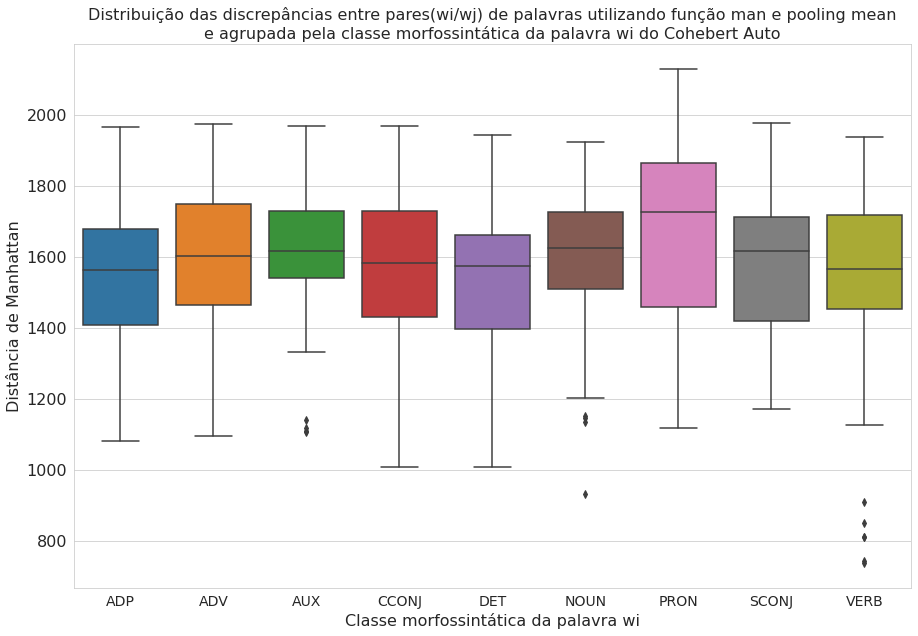

In [87]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")

# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

In [88]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,178.000000,1557.937384,167.330832,1043.523700,1432.658900,1583.174550,1674.121675,1904.257800
ADV,122.000000,1544.854050,182.131510,737.115970,1417.292500,1592.261600,1655.049275,1895.894800
AUX,36.000000,1394.557917,97.612609,1167.783200,1366.255400,1413.474000,1468.741850,1529.963500
CCONJ,148.000000,1583.203665,189.817013,1007.830000,1490.562000,1630.955800,1707.644850,2028.651700
DET,363.000000,1557.586166,210.055723,744.366640,1433.524100,1584.875000,1706.266750,2016.698700
NOUN,656.000000,1636.310015,204.634619,849.933960,1493.305200,1625.897450,1791.996700,2129.081300
PRON,105.000000,1719.098102,213.098920,1307.545500,1567.320300,1726.664100,1882.450400,2109.698700
PUNCT,394.000000,1584.799845,207.781483,1059.640300,1470.470775,1633.168950,1733.676100,1938.451800
SCONJ,36.000000,1525.109256,169.610005,1205.528900,1441.905875,1537.057750,1657.477425,1904.801000


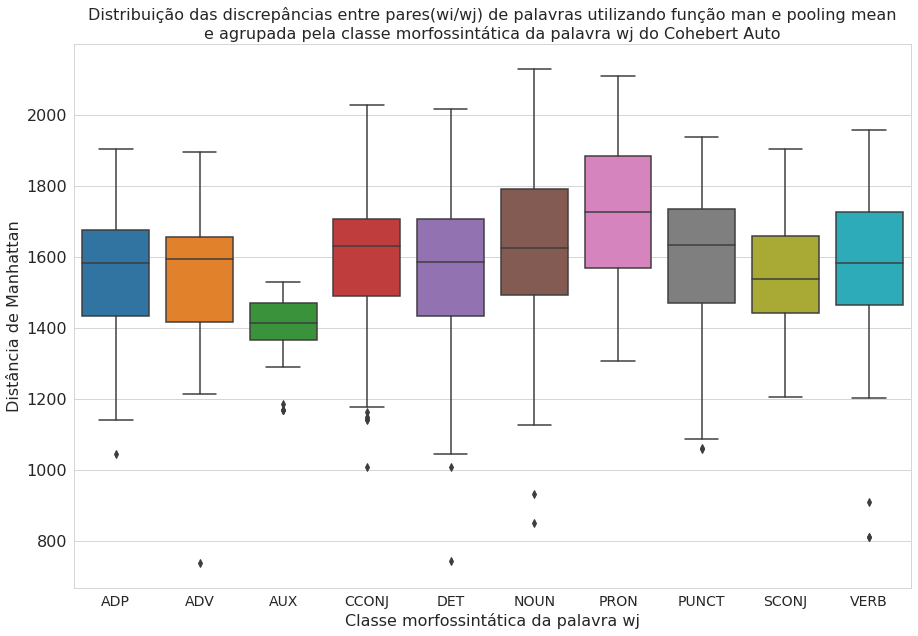

In [89]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

#### MAX

In [90]:
estrategia_pooling = "max"
coluna_equacao = medida + "_" + estrategia_pooling

In [91]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,188.000000,1577.765238,200.972246,1081.562100,1437.413900,1593.336550,1740.837275,1975.189500
ADV,159.000000,1689.623289,236.718589,1095.593100,1548.902800,1717.166300,1876.265050,2167.356400
AUX,192.000000,1676.555643,188.199835,1107.207200,1549.630150,1655.871500,1811.306825,2129.116700
CCONJ,166.000000,1638.620276,241.073105,1007.830000,1487.607850,1680.687150,1817.012900,2100.799000
DET,349.000000,1582.150019,200.407053,1007.936700,1458.676400,1602.334700,1689.582400,2149.620600
NOUN,447.000000,1708.701958,157.289926,931.861000,1606.977250,1725.729700,1813.394900,2098.705600
PRON,346.000000,1699.861669,279.604455,1118.241500,1468.741850,1758.846950,1910.550500,2301.813700
SCONJ,129.000000,1639.401811,206.463393,1170.552200,1555.715300,1673.446900,1768.445000,2050.781500
VERB,264.000000,1745.065473,195.246790,949.523700,1641.194050,1772.802450,1873.805950,2162.927200


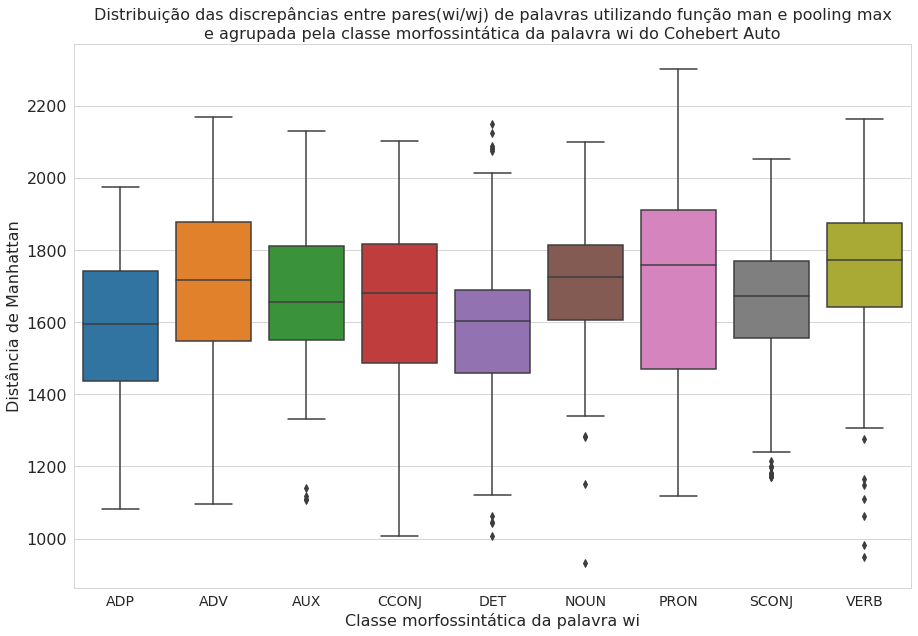

In [92]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")

# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

In [93]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,178.000000,1621.325433,183.578573,1043.523700,1522.502200,1642.941400,1735.799525,2080.503200
ADV,122.000000,1662.630867,246.462965,949.523700,1520.386675,1636.499750,1839.521125,2301.813700
AUX,36.000000,1394.557917,97.612609,1167.783200,1366.255400,1413.474000,1468.741850,1529.963500
CCONJ,148.000000,1612.285571,198.778593,1007.830000,1518.236250,1659.354200,1744.439125,2028.651700
DET,363.000000,1610.661064,222.138078,981.509300,1490.688050,1632.464200,1747.251150,2167.356400
NOUN,656.000000,1730.418250,197.465828,931.861000,1584.640900,1755.400350,1869.709425,2267.107000
PRON,105.000000,1747.111006,213.699866,1307.545500,1610.796100,1762.148700,1905.436000,2109.698700
PUNCT,394.000000,1626.478777,230.439133,1059.640300,1538.206325,1666.042850,1788.724325,2162.927200
SCONJ,36.000000,1545.372019,193.280886,1205.528900,1441.905875,1542.393900,1663.537175,1904.801000


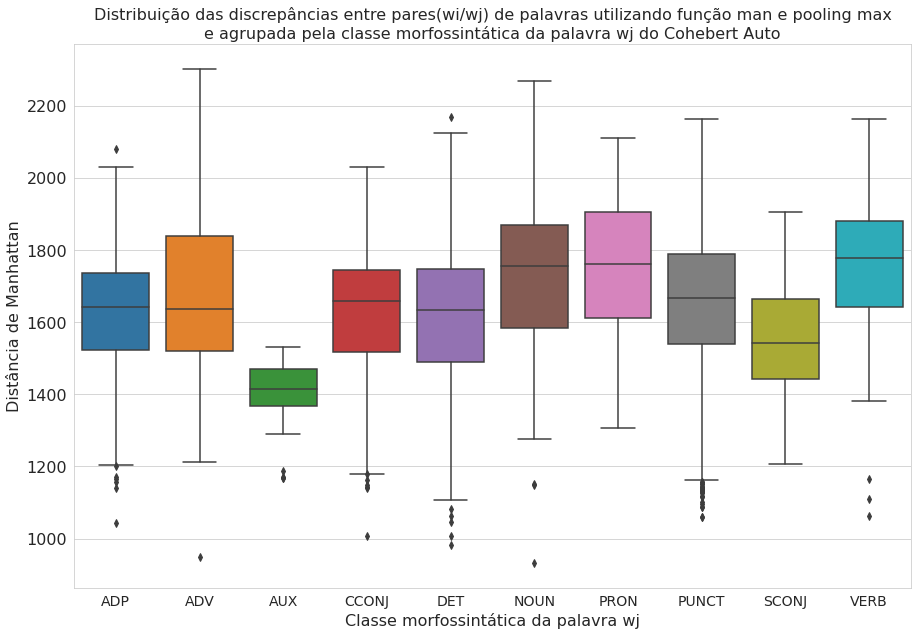

In [94]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

## 3.5 Estatísticas das discrepâncias de determinados pares de palavras

### Geral

Conta pares de classes de palavras

In [95]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_bar = tqdm_notebook(lista_comparacao_palavra.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_palavra))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_bar:  
  #if i < 10:             
    contador[linha_comparacao["pos_i"]+"/"+linha_comparacao["pos_j"]] += 1

Documentos:   0%|          | 0/2240 [00:00<?, ? documento/s]

Ordenada as contagens dos pares

In [96]:
top = 10
dicdados = {}
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    dicdados.update({item: contador[item]})    

Mostra o gráfico

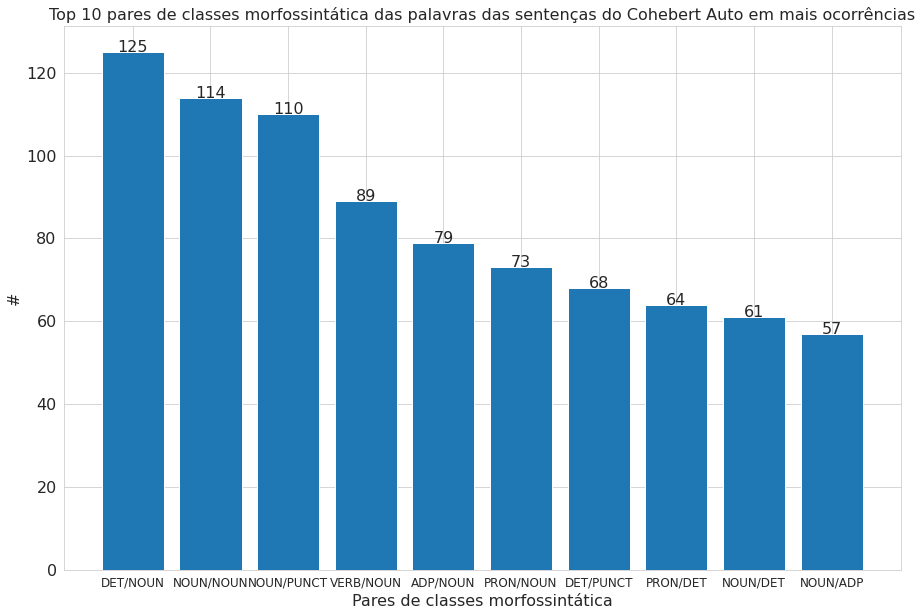

In [97]:
# Import da biblioteca
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
plt.figure(figsize =(15, 10))

# Recupera os rótulos e os valores
rotulos = list(dicdados.keys())
valores = list(dicdados.values())

# Título do gráfico
plt.title("Top 10 pares de classes morfossintática das palavras das sentenças do Cohebert Auto em mais ocorrências")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintática")
# Texto do eixo y
plt.ylabel("#")

# Insere os dados no gráfico
plt.bar(rotulos, valores)

plt.xticks(fontsize=12)

# Adiciona os rótulos as barras
for i in range(len(valores)):
  plt.annotate(str(valores[i]), xy = (rotulos[i], valores[i]), ha = "center")

# Mostra o gráfico
plt.show()

### VERB-VERB

#### Estatísticas

Filtrar comparação verbos com verbos

In [98]:
lista_comparacao_classes = lista_comparacao_palavra[(lista_comparacao_palavra["pos_i"] == "VERB") & (lista_comparacao_palavra["pos_j"] == "VERB")]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 15


Estatísticas das medidas dos pares de palavras

In [99]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.693048,29.678191,1428.343287,0.631684,35.212975,1686.755840
std,0.118939,7.455107,350.427124,0.119884,6.846304,323.633289
min,0.518476,16.538916,809.813400,0.479000,22.114347,1061.891500
25%,0.618561,25.523087,1243.009800,0.571157,33.962440,1649.372000
50%,0.631299,32.502270,1565.047400,0.612395,36.584511,1786.097200
75%,0.778820,35.035847,1674.861600,0.649342,38.987669,1868.660700
max,0.894137,39.396168,1894.734900,0.853132,43.756317,2065.714800


#### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB e pos(wj) do tipo VERB

In [100]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wi"]] += 1

Documentos:   0%|          | 0/15 [00:00<?, ? documento/s]

In [101]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [102]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque       palavra  #wi
      1 implementadas    7
      2      empilhar    5
      3       separar    2
      4    enfileirar    1


Top 20 palavras(wj) em mais ocorrências nas comparações de pos(wi) do tipo VERB e pos(wj) do tipo VERB

In [103]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wj"]] += 1

Documentos:   0%|          | 0/15 [00:00<?, ? documento/s]

In [104]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])     

In [105]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wj"))

# Motra o rank
print(df1.to_string(index=False))

 ranque       palavra  #wj
      1   desempilhar    5
      2      empilhar    2
      3     organizar    2
      4 desenfileirar    2
      5        ocorre    2
      6    enfileirar    1
      7       separar    1


#### COS

In [106]:
medida = "cos_mean"

Documentos outliers

In [107]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.16025963425636292
Limite superior             : 1.0192097574472427
Limite inferior             : 0.3781712204217911


Encontra os documentos com as maiores discrepâncias (cos(wi,wj) < limite_inferior)

In [108]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

  print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 15 ( 0.0 )


Encontra os documentos com as maiores similaridades (cos(wi,wj) > limite_superior)

In [109]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

  print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 15 ( 0.0 )


In [110]:
if len(lista_comparacao_classes[medida]) != 0:
  totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
  print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 15 ( 0.0 )


Top 5 documentos com as maiores similaridades (cos(wi,wj) > limite_superior) entre palavras da classe VERB

In [111]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (cos(wi,wj) < limite_inferior) entre palavras da classe VERB

In [112]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

#### EUC

In [113]:
medida = "euc_mean"

Documentos outliers

In [114]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 9.512760162353516
Limite superior             : 49.30498695373535
Limite inferior             : 11.253946304321289


Encontra os documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior)

In [115]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 15 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,wj) < limite_inferior)

In [116]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 15 ( 0.0 )


In [117]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 15 ( 0.0 )


Top 5 documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior) entre palavras da classe VERB


In [118]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe VERB


In [119]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

#### MAN

In [120]:
medida = "man_mean"

Documentos outliers

In [121]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 431.8517999999999
Limite superior             : 2322.6393
Limite inferior             : 595.2321000000002


Encontra os documentos com as maiores discrepâncias (man(wi,wj) > limite_superior)

In [122]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 15 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [123]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 15 ( 0.0 )


In [124]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 15 ( 0.0 )


Top 5 documentos com as maiores discrepâncias (man(wi,wj) > limite_superior) entre palavras da classe VERB

In [125]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (man(wi,wj) < limite_inferior) entre palavras da classe VERB

In [126]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

### NOUN-NOUN

#### Estatísticas

Filtrar comparação verbos com verbos

In [127]:
lista_comparacao_classes = lista_comparacao_palavra[(lista_comparacao_palavra["pos_i"] == "NOUN") & (lista_comparacao_palavra["pos_j"] == "NOUN")]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 114


Estatísticas das medidas dos pares de palavras

In [128]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,0.683541,32.254386,1518.367091,0.647719,34.700549,1647.691232
std,0.044694,2.844431,129.960838,0.065453,3.688473,183.281622
min,0.569912,19.861835,931.861000,0.488576,19.861835,931.861000
25%,0.661913,30.835185,1459.038650,0.608861,32.192708,1524.453475
50%,0.684257,32.307495,1521.752850,0.650137,35.144089,1677.903700
75%,0.708116,34.271113,1603.323050,0.694021,37.050757,1759.958325
max,0.871600,37.666870,1785.289800,0.871600,42.769478,2095.236600


#### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [129]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wi"]] += 1

Documentos:   0%|          | 0/114 [00:00<?, ? documento/s]

In [130]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [131]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque     palavra  #wi
      1   elementos   29
      2 desempilhar   18
      3        fila   15
      4   estrutura   13
      5       pilha   12
      6       dados    9
      7   operações    8
      8    operação    6
      9      árvore    2
     10       carga    1
     11     entrada    1


Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [132]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wj"]] += 1

Documentos:   0%|          | 0/114 [00:00<?, ? documento/s]

In [133]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])     

In [134]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wj"))

# Motra o rank
print(df1.to_string(index=False))

 ranque     palavra  #wj
      1        fila   32
      2       dados   16
      3    elemento   14
      4   elementos   13
      5 extremidade   10
      6   estrutura    9
      7       pilha    8
      8 desempilhar    4
      9    operação    4
     10       carga    2
     11     entrada    2


#### COS

In [135]:
medida = "cos_mean"

Documentos outliers

In [136]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.04620295763015747
Limite superior             : 0.7774206697940826
Limite inferior             : 0.5926088392734528


Encontra os documentos com as maiores discrepâncias (cos(wi,wj) < limite_inferior)

In [137]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

  print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 3 de 114 ( 0.02631578947368421 )


Encontra os documentos com as maiores similaridades (cos(wi,wj) > limite_superior)

In [138]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

  print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 4 de 114 ( 0.03508771929824561 )


In [139]:
if len(lista_comparacao_classes[medida]) != 0:
  totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
  print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  7 de 114 ( 0.06140350877192982 )


Top 5 documentos com as maiores similaridades (cos(wi,wj) > limite_superior) entre palavras da classe VERB

In [140]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 0.871599555015564 dados dados
         Como desempilhar dados em uma estrutura de dados fila ? 0

 2 0.7875463962554932 pilha carga
         Em uma pilha a operação de carga ocorre em qual extremidade ? 0

 3 0.781815767288208 desempilhar fila
         Como desempilhar elementos em uma fila? 1

 4 0.778991162776947 estrutura elemento
         O que é uma estrutura e como desenfileirar um elemento nela ? 0


Top 5 documentos com as maiores similaridades (cos(wi,wj) < limite_inferior) entre palavras da classe VERB

In [141]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 0.5699121952056885 operações fila
         Como são implementadas as operações de empilhar e organizar elementos em uma fila ? 0

 2 0.5704489946365356 operações fila
         Como são implementadas as operações de empilhar e desempilhar elementos em uma fila? 1

 3 0.5742012858390808 operações pilha
         Como são implementadas as operações de enfileirar e desenfileirar elementos em uma pilha? 1


#### EUC

In [142]:
medida = "euc_mean"

Documentos outliers

In [143]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.4359288215637207
Limite superior             : 39.4250066280365
Limite inferior             : 25.681291341781616


Encontra os documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior)

In [144]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (euc(wi,wj) < limite_inferior)

In [145]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 3 de 114 ( 0.02631578947368421 )


In [146]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3 de 114 ( 0.02631578947368421 )


Top 5 documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior) entre palavras da classe NOUN

In [147]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido       
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe NOUN


In [148]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1


 1 19.861835479736328 dados dados
         Como desempilhar dados em uma estrutura de dados fila ? 0

 2 23.661399841308597 desempilhar fila
         Como desempilhar elementos em uma fila? 1

 3 25.15181541442871 pilha carga
         Em uma pilha a operação de carga ocorre em qual extremidade ? 0


#### MAN

In [149]:
medida = "man_mean"

Documentos outliers

In [150]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 144.2844
Limite superior             : 1819.74965
Limite inferior             : 1242.61205


Encontra os documentos com as maiores discrepâncias (man(wi,wj) > limite_superior)

In [151]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [152]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 3 de 114 ( 0.02631578947368421 )


In [153]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3 de 114 ( 0.02631578947368421 )


Top 5 documentos com as maiores discrepâncias (man(wi,wj) > limite_superior) entre palavras da classe NOUN

In [154]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]] 
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"] 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1

Top 5 documentos com as maiores similaridades (man(wi,wj) < limite_superior) entre palavras da classe NOUN

In [155]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 931.861 dados dados
         Como desempilhar dados em uma estrutura de dados fila ? 0

 2 1134.9348 desempilhar fila
         Como desempilhar elementos em uma fila? 1

 3 1151.9889 pilha carga
         Em uma pilha a operação de carga ocorre em qual extremidade ? 0


### NOUN-VERB

#### Estatísticas

Filtrar comparação verbos com verbos

In [156]:
lista_comparacao_classes = lista_comparacao_palavra[(lista_comparacao_palavra["pos_i"] == "NOUN") & (lista_comparacao_palavra["pos_j"] == "VERB")]

lista_comparacao_classesNV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 33


Estatísticas das medidas dos pares de palavras

In [157]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,0.644515,33.485895,1589.149385,0.590158,37.081717,1757.539194
std,0.052940,3.696675,167.168777,0.080862,3.898268,177.005042
min,0.551273,25.232309,1214.173800,0.461992,28.882858,1381.870400
25%,0.600362,31.998394,1524.226800,0.529975,35.083996,1701.497200
50%,0.633397,33.644779,1615.846100,0.582893,37.878956,1783.391800
75%,0.672613,35.970715,1722.836400,0.632596,39.816452,1867.879900
max,0.755604,39.607944,1840.356900,0.729381,42.988266,2084.200700


#### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo VERB

In [158]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wi"]] += 1

Documentos:   0%|          | 0/33 [00:00<?, ? documento/s]

In [159]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [160]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque   palavra  #wi
      1      fila    9
      2     pilha    9
      3 operações    7
      4  operação    6
      5     carga    1
      6   entrada    1


Top 20 palavras(wj) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo VERB

In [161]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wj"]] += 1

Documentos:   0%|          | 0/33 [00:00<?, ? documento/s]

In [162]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])     

In [163]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wj"))

# Motra o rank
print(df1.to_string(index=False))

 ranque       palavra  #wj
      1        ocorre   10
      2      empilhar    7
      3    enfileirar    6
      4   identificar    2
      5       colocar    2
      6     organizar    2
      7       separar    2
      8   desempilhar    1
      9 desenfileirar    1


#### COS

In [164]:
medida = "cos_mean"

Documentos outliers

In [165]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.07225161790847778
Limite superior             : 0.7809906899929047
Limite inferior             : 0.49198421835899353


Encontra os documentos com as maiores discrepâncias (cos(wi,wj) < limite_inferior)

In [166]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

  print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 33 ( 0.0 )


Encontra os documentos com as maiores similaridades (cos(wi,wj) > limite_superior)

In [167]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

  print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 33 ( 0.0 )


In [168]:
if len(lista_comparacao_classes[medida]) != 0:
  totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
  print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 33 ( 0.0 )


Top 5 documentos com as maiores similaridades (cos(wi,wj) > limite_superior) entre palavras da classe VERB

In [169]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (cos(wi,wj) < limite_inferior) entre palavras da classe VERB

In [170]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

#### EUC

In [171]:
medida = "euc_mean"

Documentos outliers

In [172]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.9723205566406286
Limite superior             : 41.92919540405274
Limite inferior             : 26.039913177490227


Encontra os documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior)

In [173]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 33 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,wj) < limite_inferior)

In [174]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 3 de 33 ( 0.09090909090909091 )


In [175]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3 de 33 ( 0.09090909090909091 )


Top 5 documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior) entre palavras da classe NOUN e VERB

In [176]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe NOUN e VERB


In [177]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 25.232309341430664 fila empilhar
         O que é uma fila e como empilhar um elemento nela? 1

 2 25.61684799194336 fila empilhar
         Em uma fila a operação de empilhar ocorre em qual extremidade? 1

 3 25.677810668945312 fila empilhar
         O que é uma fila e como empilhar seu elemento? 1


#### MAN

In [178]:
medida = "man_mean"

Documentos outliers

In [179]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 198.6096
Limite superior             : 2020.7507999999998
Limite inferior             : 1226.3123999999998


Encontra os documentos com as maiores discrepâncias (man(wi,wj) > limite_superior)

In [180]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 33 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)


In [181]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1 de 33 ( 0.030303030303030304 )


In [182]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1 de 33 ( 0.030303030303030304 )


Top 5 documentos com as maiores discrepâncias (man(wi,wj) > limite_superior) entre palavras da classe NOUN e VERB

In [183]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (man(wi,wj) < limite_superior) entre palavras da classe NOUN e VERB


In [184]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 1214.1738 fila empilhar
         O que é uma fila e como empilhar um elemento nela? 1


### VERB-NOUN

#### Estatísticas

Filtrar comparação verbos com verbos

In [185]:
lista_comparacao_classes = lista_comparacao_palavra[(lista_comparacao_palavra["pos_i"] == "VERB") & (lista_comparacao_palavra["pos_j"] == "NOUN")]

lista_comparacao_classesVN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 89


Estatísticas das medidas dos pares de palavras

In [186]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_mean", "euc_mean","man_mean"]].describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean
count,89.000000,89.000000,89.000000
mean,0.665577,32.671713,1551.812818
std,0.060113,4.023201,188.693905
min,0.533435,17.615896,849.933960
25%,0.633480,30.557777,1437.339400
50%,0.671897,33.024475,1559.585200
75%,0.704407,34.731720,1669.556300
max,0.872450,39.603531,1873.293200


#### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB e pos(wj) do tipo NOUN

In [187]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wi"]] += 1

Documentos:   0%|          | 0/89 [00:00<?, ? documento/s]

In [188]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [189]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque       palavra  #wi
      1      empilhar   21
      2 implementadas   12
      3       colocar   10
      4   desempilhar   10
      5    enfileirar    8
      6       separar    5
      7    introduzir    5
      8 desenfileirar    4
      9     adicionar    4
     10     organizar    4
     11        ocorre    4
     12   identificar    2


Top 20 palavras(wj) em mais ocorrências nas comparações de pos(wi) do tipo VERB e pos(wj) do tipo NOUN

In [190]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wj"]] += 1

Documentos:   0%|          | 0/89 [00:00<?, ? documento/s]

In [191]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])     

In [192]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wj"))

# Motra o rank
print(df1.to_string(index=False))

 ranque     palavra  #wj
      1   elementos   31
      2        fila   18
      3       pilha    9
      4    elemento    8
      5 extremidade    6
      6   estrutura    5
      7       dados    5
      8   operações    4
      9 desempilhar    3


#### COS

In [193]:
medida = "cos_mean"

Documentos outliers

In [194]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.07092618942260742
Limite superior             : 0.8107959032058716
Limite inferior             : 0.5270911455154419


Encontra os documentos com as maiores discrepâncias (cos(wi,wj) < limite_inferior)

In [195]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

  print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 89 ( 0.0 )


Encontra os documentos com as maiores similaridades (cos(wi,wj) > limite_superior)

In [196]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

  print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1 de 89 ( 0.011235955056179775 )


In [197]:
if len(lista_comparacao_classes[medida]) != 0:
  totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
  print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1 de 89 ( 0.011235955056179775 )


Top 5 documentos com as maiores similaridades (cos(wi,wj) > limite_superior) entre palavras da classe VERB

In [198]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1


 1 0.8724501132965088 empilhar desempilhar
         O que é uma fila e como empilhar e desempilhar seus elementos? 1


Top 5 documentos com as maiores similaridades (cos(wi,wj) < limite_inferior) entre palavras da classe VERB

In [199]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1

#### EUC

In [200]:
medida = "euc_mean"

Documentos outliers

In [201]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.173942565917965
Limite superior             : 40.99263381958007
Limite inferior             : 24.29686355590821


Encontra os documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior)

In [202]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 89 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,wj) < limite_inferior)

In [203]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 3 de 89 ( 0.033707865168539325 )


In [204]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3 de 89 ( 0.033707865168539325 )


Top 5 documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior) entre palavras da classe VERB e NOUN

In [205]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe VERB e NOUN

In [206]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"]) 
          cont = cont + 1


 1 17.615896224975586 empilhar desempilhar
         O que é uma fila e como empilhar e desempilhar seus elementos? 1

 2 23.63708877563477 empilhar fila
         Como empilhar elementos em uma fila? 1

 3 23.757408142089844 empilhar fila
         Como são implementadas as operações de empilhar e organizar elementos em uma fila ? 0


#### MAN

In [207]:
medida = "man_mean"

Documentos outliers

In [208]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 232.2168999999999
Limite superior             : 2017.8816499999998
Limite inferior             : 1089.0140500000002


Encontra os documentos com as maiores discrepâncias (man(wi,wj) > limite_superior)

In [209]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 89 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [210]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1 de 89 ( 0.011235955056179775 )


In [211]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1 de 89 ( 0.011235955056179775 )


Top 5 documentos com as maiores discrepâncias (man(wi,wj) > limite_superior) entre palavras da classe VERB e NOUN

In [212]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1

Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe VERB e NOUN

In [213]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 849.93396 empilhar desempilhar
         O que é uma fila e como empilhar e desempilhar seus elementos? 1


### Comparando discrepância entre pares de palavras de determinadas classes

#### COS, EUC, MAN

In [214]:
df_all = pd.concat([lista_comparacao_palavra[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna(),
                    lista_comparacao_classesVV[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna(), 
                    lista_comparacao_classesNN[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna(),
                    lista_comparacao_classesNV[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna(),
                    lista_comparacao_classesVN[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna()
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                              \
         cos_mean    euc_mean    man_mean     cos_max     euc_max     man_max   
count 2240.000000 2240.000000 2240.000000 2240.000000 2240.000000 2240.000000   
mean     0.633364   33.104774 1592.776590    0.611505   34.599377 1667.621431   
std      0.118872    4.791607  204.416540    0.120943    4.973750  218.939059   
min      0.066207   15.401643  737.115970    0.066207   19.861835  931.861000   
25%      0.585832   29.952577 1463.559075    0.557982   31.565753 1537.840525   
50%      0.647013   32.969604 1604.215850    0.618849   34.873610 1689.688400   
75%      0.701122   36.218154 1733.797975    0.679508   38.065288 1819.236025   
max      0.901491   47.294228 2129.081300    0.888144   48.315918 2301.813700   

      VERB-VERB                                  ...   NOUN-VERB            \
       cos_mean  euc_mean    man_mean   cos_max  ...    man_mean   cos_max   
count 15.000000 15.000000   15.000000 15.000000  ...   33.000000 33.000000   
mean   0.693048 29.678191 1428.343287  0.631684  ... 1589.149385  0.590158   
std    0.118939  7.455107  350.427124  0.119884  ...  167.168777  0.080862   
min    0.518476 16.538916  809.813400  0.479000  ... 1214.173800  0.461992   
25%    0.618561 25.523087 1243.009800  0.571157  ... 1524.226800  0.529975   
50%    0.631299 32.502270 1565.047400  0.612395  ... 1615.846100  0.582893   
75%    0.778820 35.035847 1674.861600  0.649342  ... 1722.836400  0.632596   
max    0.894137 39.396168 1894.734900  0.853132  ... 1840.356900  0.729381   

                            VERB-NOUN                                  \
        euc_max     man_max  cos_mean  euc_mean    man_mean   cos_max   
count 33.000000   33.000000 89.000000 89.000000   89.000000 89.000000   
mean  37.081717 1757.539194  0.665577 32.671713 1551.812818  0.609260   
std    3.898268  177.005042  0.060113  4.023201  188.693905  0.075690   
min   28.882858 1381.870400  0.533435 17.615896  849.933960  0.475583   
25%   35.083996 1701.497200  0.633480 30.557777 1437.339400  0.553980   
50%   37.878956 1783.391800  0.671897 33.024475 1559.585200  0.603087   
75%   39.816452 1867.879900  0.704407 34.731720 1669.556300  0.653591   
max   42.988266 2084.200700  0.872450 39.603531 1873.293200  0.834225   

                             
        euc_max     man_max  
count 89.000000   89.000000  
mean  36.502981 1736.982071  
std    4.186673  193.733070  
min   23.921432 1147.120700  
25%   34.145458 1608.228500  
50%   36.968105 1755.286400  
75%   39.782394 1875.344200  
max   43.205223 2067.509500  

[8 rows x 30 columns]

#### COS

In [215]:
df_all = pd.concat([lista_comparacao_palavra[["cos_mean"]].dropna(),                    
                    lista_comparacao_classesVV[["cos_mean"]].dropna(), 
                    lista_comparacao_classesNN[["cos_mean"]].dropna(),
                    lista_comparacao_classesNV[["cos_mean"]].dropna(),
                    lista_comparacao_classesVN[["cos_mean"]].dropna()
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

df_all.describe(include=["float", "int"]) 

,Geral,VERB-VERB,NOUN-NOUN,NOUN-VERB,VERB-NOUN
,cos_mean,cos_mean,cos_mean,cos_mean,cos_mean
count,2240.000000,15.000000,114.000000,33.000000,89.000000
mean,0.633364,0.693048,0.683541,0.644515,0.665577
std,0.118872,0.118939,0.044694,0.052940,0.060113
min,0.066207,0.518476,0.569912,0.551273,0.533435
25%,0.585832,0.618561,0.661913,0.600362,0.633480
50%,0.647013,0.631299,0.684257,0.633397,0.671897
75%,0.701122,0.778820,0.708116,0.672613,0.704407
max,0.901491,0.894137,0.871600,0.755604,0.872450


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


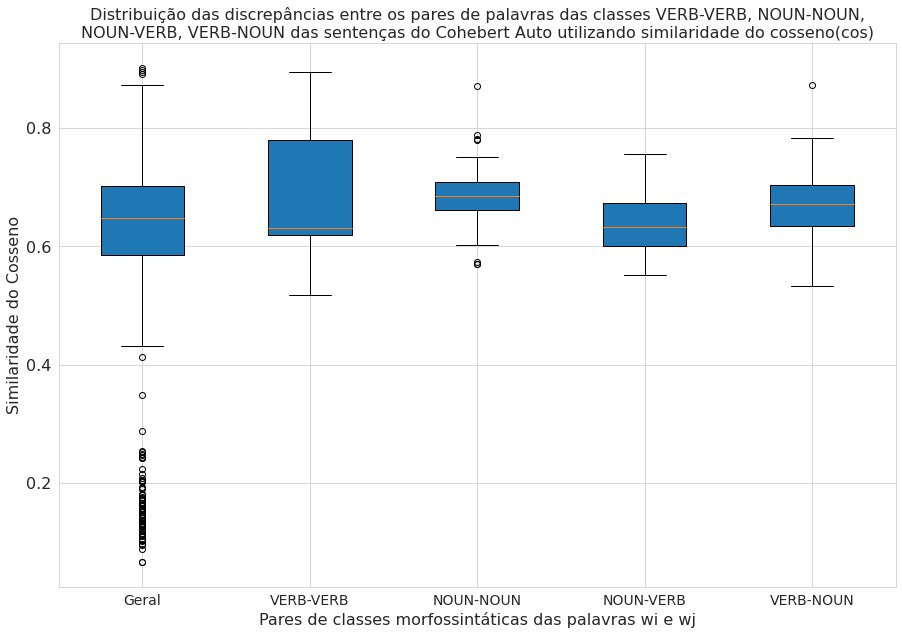

In [216]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre os pares de palavras das classes VERB-VERB, NOUN-NOUN,\nNOUN-VERB, VERB-NOUN das sentenças do Cohebert Auto utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintáticas das palavras wi e wj")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_palavra[["cos_mean"]].dropna(), 
           lista_comparacao_classesVV[["cos_mean"]].dropna(), 
           lista_comparacao_classesNN[["cos_mean"]].dropna(),
           lista_comparacao_classesNV[["cos_mean"]].dropna(),
           lista_comparacao_classesVN[["cos_mean"]].dropna()]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3, 4, 5], ["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

plt.show()

#### EUC

In [217]:
df_all = pd.concat([lista_comparacao_palavra[["euc_mean"]].dropna(),
                    lista_comparacao_classesVV[["euc_mean"]].dropna(), 
                    lista_comparacao_classesNN[["euc_mean"]].dropna(),
                    lista_comparacao_classesNV[["euc_mean"]].dropna(),
                    lista_comparacao_classesVN[["euc_mean"]].dropna()
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

df_all.describe(include=["float", "int"]) 

,Geral,VERB-VERB,NOUN-NOUN,NOUN-VERB,VERB-NOUN
,euc_mean,euc_mean,euc_mean,euc_mean,euc_mean
count,2240.000000,15.000000,114.000000,33.000000,89.000000
mean,33.104774,29.678191,32.254386,33.485895,32.671713
std,4.791607,7.455107,2.844431,3.696675,4.023201
min,15.401643,16.538916,19.861835,25.232309,17.615896
25%,29.952577,25.523087,30.835185,31.998394,30.557777
50%,32.969604,32.502270,32.307495,33.644779,33.024475
75%,36.218154,35.035847,34.271113,35.970715,34.731720
max,47.294228,39.396168,37.666870,39.607944,39.603531


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


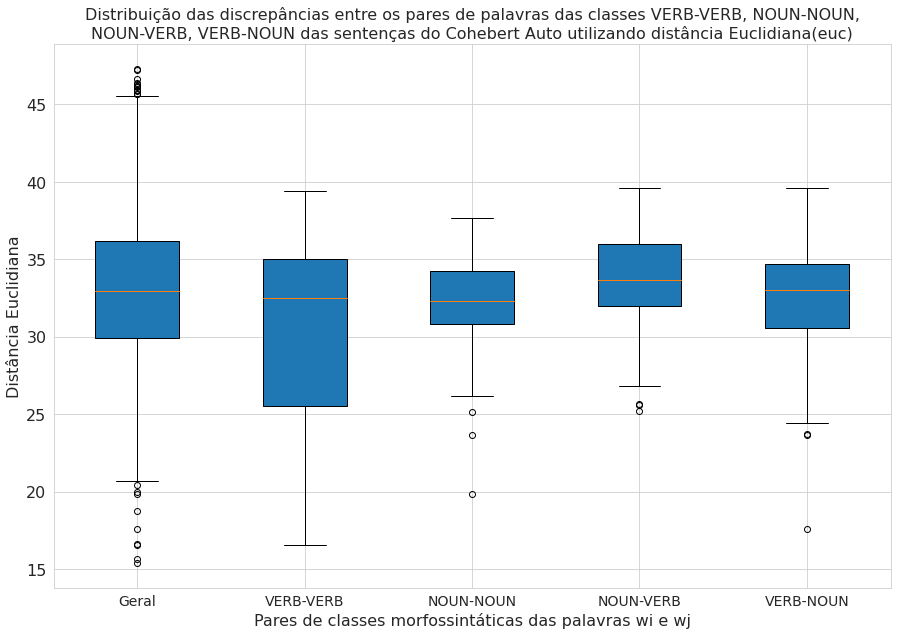

In [218]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre os pares de palavras das classes VERB-VERB, NOUN-NOUN,\nNOUN-VERB, VERB-NOUN das sentenças do Cohebert Auto utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintáticas das palavras wi e wj")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_palavra[["euc_mean"]].dropna(), 
           lista_comparacao_classesVV[["euc_mean"]].dropna(), 
           lista_comparacao_classesNN[["euc_mean"]].dropna(),
           lista_comparacao_classesNV[["euc_mean"]].dropna(),
           lista_comparacao_classesVN[["euc_mean"]].dropna()
           ]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3, 4, 5], ["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

plt.show()

#### MAN

In [219]:
df_all = pd.concat([lista_comparacao_palavra[["man_mean"]].dropna(),
                    lista_comparacao_classesVV[["man_mean"]].dropna(), 
                    lista_comparacao_classesNN[["man_mean"]].dropna(),
                    lista_comparacao_classesNV[["man_mean"]].dropna(),
                    lista_comparacao_classesVN[["man_mean"]].dropna()
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

df_all.describe(include=["float", "int"]) 

,Geral,VERB-VERB,NOUN-NOUN,NOUN-VERB,VERB-NOUN
,man_mean,man_mean,man_mean,man_mean,man_mean
count,2240.000000,15.000000,114.000000,33.000000,89.000000
mean,1592.776590,1428.343287,1518.367091,1589.149385,1551.812818
std,204.416540,350.427124,129.960838,167.168777,188.693905
min,737.115970,809.813400,931.861000,1214.173800,849.933960
25%,1463.559075,1243.009800,1459.038650,1524.226800,1437.339400
50%,1604.215850,1565.047400,1521.752850,1615.846100,1559.585200
75%,1733.797975,1674.861600,1603.323050,1722.836400,1669.556300
max,2129.081300,1894.734900,1785.289800,1840.356900,1873.293200


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


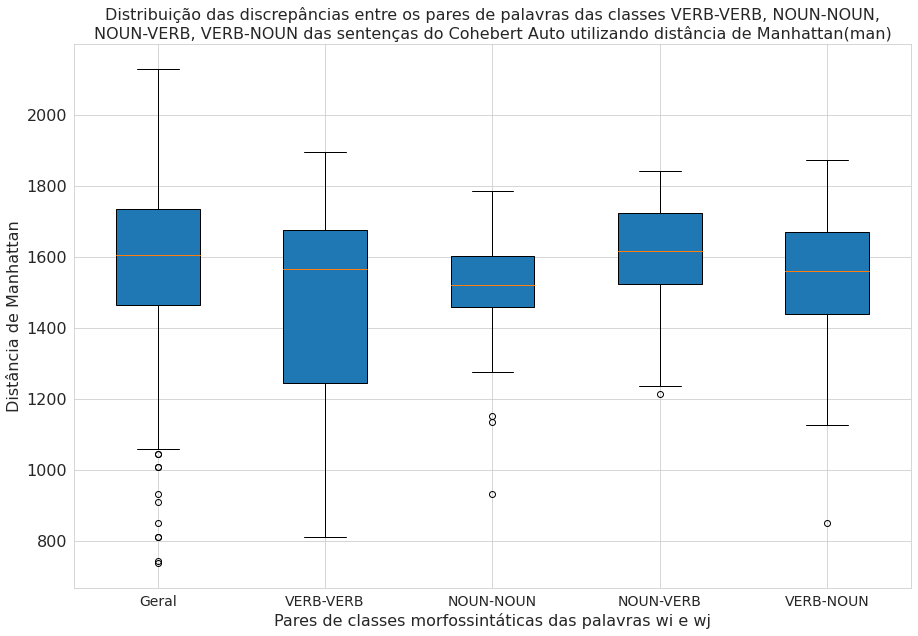

In [220]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre os pares de palavras das classes VERB-VERB, NOUN-NOUN,\nNOUN-VERB, VERB-NOUN das sentenças do Cohebert Auto utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintáticas das palavras wi e wj")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_palavra[["man_mean"]].dropna(), 
           lista_comparacao_classesVV[["man_mean"]].dropna(), 
           lista_comparacao_classesNN[["man_mean"]].dropna(),
           lista_comparacao_classesNV[["man_mean"]].dropna(),
           lista_comparacao_classesVN[["man_mean"]].dropna()
           ]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3, 4, 5], ["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

plt.show()

## 3.6 Ocorrências de pares de palavras

### Indexa os dados das comparações pelo id do documento

In [221]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_palavra_indexado = lista_comparacao_palavra.set_index(["id"])
lista_comparacao_palavra_indexado.head()

,index_documento,index_sentenca,index_wi,wi,pos_i,index_wj,wj,pos_j,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
id,,,,,,,,,,,,,,
1p0,0,0,0,Como,SCONJ,1,enfileirar,VERB,0.761694,25.747267,1281.734600,0.663389,32.028095,1584.620800
1p0,0,0,0,Como,SCONJ,2,elementos,NOUN,0.617482,35.318653,1718.498000,0.617482,35.318653,1718.498000
1p0,0,0,0,Como,SCONJ,3,em,ADP,0.650087,33.424171,1681.771700,0.650087,33.424171,1681.771700
1p0,0,0,0,Como,SCONJ,4,uma,DET,0.704987,29.126415,1443.124000,0.704987,29.126415,1443.124000
1p0,0,0,0,Como,SCONJ,5,pilha,NOUN,0.603006,34.711918,1627.421800,0.603006,34.711918,1627.421800


### 3.6.1 Similaridade coseno

#### 3.6.1.1 Organiza as comparações das palavras antes e depois da palavra chave

In [222]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'cos'

# Estratégia medida
estrategia_medida = 'mean'

# Palavra a ser procurada
palavra_chave = "pilha"

# Constroi uma lista com as palavras próximas
lista_proximidade_chave = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações com a palavra chave
    lista_proximidade_chave_documento = []

    # Localiza as comparações de um documento
    lista_comp = lista_comparacao_palavra_indexado.loc[linha1['id']]
    
    # Analisa as palavras após a chave
    for i, linha in lista_comp.iterrows():
      
        # Verifica se a palavra wi é igual a chave
        if linha['wi'].lower() == palavra_chave.lower():
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[medida + '_' + estrategia_medida]

          # Guarda os dados da comparação          
          lista_proximidade_chave_documento.append([linha['wi'],        # 0
                                                    linha['pos_i'],     # 1
                                                    linha['wj'],        # 2
                                                    linha['pos_j'],     # 3
                                                    linha['cos_mean'],  # 4
                                                    linha['euc_mean'],  # 5
                                                    linha['man_mean'],  # 6
                                                    linha['cos_max'],   # 7
                                                    linha['euc_max'],   # 8
                                                    linha['man_max'],   # 9
                                                    ])

    # Analisa as palavras antes dda chave
    for i, linha in lista_comp.iterrows():
      
        # Verifica se a palavra wj é igual a chave
        if linha['wj'].lower() == palavra_chave.lower():          
          # Conta o número de comparações
          conta = conta + 1

          # Acumula medida
          soma_medida = soma_medida +  linha[medida + '_' + estrategia_medida]
          
          # Guarda os dados da comparação
          lista_proximidade_chave_documento.append([linha['wj'],        # 0
                                                    linha['pos_j'],     # 1
                                                    linha['wi'],        # 2
                                                    linha['pos_i'],     # 3
                                                    linha['cos_mean'],  # 4
                                                    linha['euc_mean'],  # 5
                                                    linha['man_mean'],  # 6
                                                    linha['cos_max'],   # 7
                                                    linha['euc_max'],   # 8
                                                    linha['man_max'],   # 9                                                    
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade_chave.append([linha1['id'], lista_proximidade_chave_documento])

print("Número de comparações com ", palavra_chave, " : ", conta)
media = soma_medida / conta
print("Média medida", (medida + "_" + estrategia_medida), " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações com  pilha  :  149
Média medida cos_mean  :  0.5948485352048938


#### 3.6.1.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [223]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_chave_bar = tqdm_notebook(enumerate(lista_proximidade_chave), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade_chave))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_chave_bar:
  # if i < 5:

    # Verifica se existe comparações com a chave no documento
    if len(linha1[1]) != 0:

      # Percorre as comparações com a palavra chave no documento
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[4] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") " + linha2[2] + "(" + linha2[3] + ")"

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.1.3 Lista as 20 maiores ocorrências de pares de palavras com similaridade acima do threshold

In [224]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de pares de palavras com similaridade do cosseno acima do threshold")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):

  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de pares de palavras com similaridade do cosseno acima do threshold
1 pilha(NOUN) ?(PUNCT) 15
2 pilha(NOUN) uma(DET) 15
3 pilha(NOUN) elementos(NOUN) 8
4 pilha(NOUN) em(ADP) 8
5 pilha(NOUN) e(CCONJ) 8
6 pilha(NOUN) enfileirar(VERB) 6
7 pilha(NOUN) como(ADV) 6
8 pilha(NOUN) é(AUX) 6
9 pilha(NOUN) elemento(NOUN) 5
10 pilha(NOUN) Como(SCONJ) 4
11 pilha(NOUN) O(PRON) 4
12 pilha(NOUN) colocar(VERB) 3
13 pilha(NOUN) desenfileirar(ADV) 3
14 pilha(NOUN) um(DET) 3
15 pilha(NOUN) nela(PRON) 3
16 pilha(NOUN) de(SCONJ) 3
17 pilha(NOUN) desenfileirar(VERB) 2
18 pilha(NOUN) seu(DET) 2
19 pilha(NOUN) seus(DET) 2
20 pilha(NOUN) separar(VERB) 2


### 3.6.2 Raio de proximidade

#### 3.6.2.1 Organiza as comparações das palavras antes e depois da palavra chave

In [225]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Palavra a ser procurada
palavra_chave = "pilha"

# Constroi uma lista com as palavras próximas
lista_proximidade_chave = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações com a palavra chave
    lista_proximidade_chave_documento = []

    # Localiza as comparações de um documento
    lista_comp = lista_comparacao_palavra_indexado.loc[linha1['id']]
    
    # Analisa as palavras após a chave
    for i, linha in lista_comp.iterrows():
      
        # Verifica se a palavra wi é igual a chave
        if linha['wi'].lower() == palavra_chave.lower():
          # Conta o número de comparações
          conta = conta + 1

          # Calcula a distância da chaves 
          distancia = abs(linha['index_wj'] - linha['index_wi'])
            
          # Guarda os dados da comparação          
          lista_proximidade_chave_documento.append([linha['wi'],        # 0
                                                    linha['pos_i'],     # 1
                                                    linha['wj'],        # 2
                                                    linha['pos_j'],     # 3                                                    
                                                    distancia,          # 4
                                                    ])

    # Analisa as palavras antes dda chave
    for i, linha in lista_comp.iterrows():
      
        # Verifica se a palavra wj é igual a chave
        if linha['wj'].lower() == palavra_chave.lower():          
          # Conta o número de comparações
          conta = conta + 1
          
          # Calcula a distância da chaves 
          distancia = abs(linha['index_wi'] - linha['index_wj'])
          
          # Guarda os dados da comparação
          lista_proximidade_chave_documento.append([linha['wj'],        # 0
                                                    linha['pos_j'],     # 1
                                                    linha['wi'],        # 2
                                                    linha['pos_i'],     # 3                                                    
                                                    distancia,          # 4
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade_chave.append([linha1['id'], lista_proximidade_chave_documento])

print("Número de comparações com ", palavra_chave, " : ", conta)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações com  pilha  :  149


#### 3.6.2.2 Seleciona comparações entre palavras que esteja a um determinado raio ao redor da palavra chave

In [226]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
raio = 2

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_chave_bar = tqdm_notebook(enumerate(lista_proximidade_chave), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade_chave))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_chave_bar:
  # if i < 5:

    # Verifica se existe comparações com a chave no documento
    if len(linha1[1]) != 0:

      # Percorre as comparações com a palavra chave no documento
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do raio
        if linha2[4] <= raio:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") - " + str(linha2[4]) + " - " + linha2[2] + "(" + linha2[3] + ")"
            
            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.2.3 Lista ordenada das 20 maiores ocorrências de pares de palavras até o raio

In [227]:
top = 20

print("Lista ordenada das", top, "maiores ocorrências de pares de palavras contendo a palavra chave com proximidade até o raio")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das 20 maiores ocorrências de pares de palavras contendo a palavra chave com proximidade até o raio
1 pilha(NOUN) - 1 - uma(DET) 15
2 pilha(NOUN) - 1 - e(CCONJ) 7
3 pilha(NOUN) - 2 - é(AUX) 7
4 pilha(NOUN) - 1 - ?(PUNCT) 6
5 pilha(NOUN) - 2 - em(ADP) 6
6 pilha(NOUN) - 2 - como(ADV) 6
7 pilha(NOUN) - 1 - a(DET) 2
8 pilha(NOUN) - 2 - operação(NOUN) 2
9 pilha(NOUN) - 2 - Em(ADP) 2
10 pilha(NOUN) - 2 - como(SCONJ) 1


# 4 Finalização

## 4.1 Tempo final de processamento



In [228]:
# Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print("")
print("  Tempo processamento:  {:} (h:mm:ss)".format(tempo_total_processamento))


  Tempo processamento:  0:01:20 (h:mm:ss)
